## Recommender Systems

In [1]:
# Import libraries
import re
import scipy as sp
import scipy.io
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# Load Data
data = scipy.io.loadmat('/Users/wiseer85/Documents/Data Science/ML Exercises/data/ex8_movies.mat')

In [5]:
Y = data['Y']
R = data['R']

In [6]:
data_movie_ids = sp.loadtxt('/Users/wiseer85/Documents/Data Science/ML Exercises/data/movie_ids.txt', dtype='string', delimiter='\n')

TypeError: data type "string" not understood

In [5]:
index_movie_list = [re.split(' ', row, maxsplit=1) for row in data_movie_ids]
movie_index_dict = {movie: int(index) - 1 for index, movie in index_movie_list}

### 2.1 Movie ratings dataset

In [120]:
index = movie_index_dict['Toy Story (1995)']
print sp.mean(Y[index][R[index] == 1])

3.87831858407


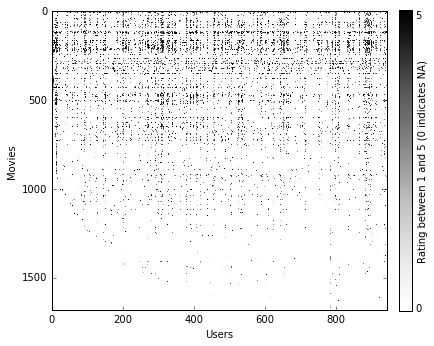

In [121]:
fig = plt.figure(figsize=(6,6))
imshow_out = plt.imshow(Y, cmap=plt.get_cmap('Greys'), vmin=0, vmax=5, interpolation = 'nearest', aspect=0.5)
plt.xlabel('Users')
plt.ylabel('Movies')

ax_cb = fig.add_axes([0.93, 0.165, 0.03, 0.695])
markersize = plt.rcParams['lines.markersize'] # The adjustments to 'lines.markersize' in this code block prevent points of size "markersize" from appearing in the corners of the colorbar.
plt.rcParams['lines.markersize'] = 0.1 
fig.colorbar(imshow_out, cax=ax_cb, ticks=[])
ax_cb.text(1.2, 0.010, '0', verticalalignment='center', horizontalalignment='left')
ax_cb.text(1.2, 0.985, '5', verticalalignment='center', horizontalalignment='left')
ax_cb.text(1.4, 0.5, 'Rating between 1 and 5 (0 indicates NA)', verticalalignment='center', horizontalalignment='left', rotation=90)
plt.rcParams['lines.markersize'] = markersize   

## 2.2 Collaborative filtering learning algorithm

### 2.2.1 Collaborative filtering cost function

In [6]:
movies_params_dict = scipy.io.loadmat('ex8/ex8_movieParams.mat')

In [11]:
X = movies_params_dict['X']
Theta = movies_params_dict['Theta']

In [145]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)
    return cost

In [12]:
# Cost function and gradients will be tested on a subset of the data.
num_features = 3
num_users = 4
num_movies = 5

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

params = sp.hstack((X.ravel(), Theta.ravel()))

In [147]:
print "Cost at loaded parameters:", cofi_cost_func(params, Y, R, num_users, num_movies, num_features)

Cost at loaded parameters: 22.2246037257


### 2.2.2 Collaborative filtering gradient

In [154]:
def cofi_cost_grad_func(params, Y, R, num_users, num_movies, num_features):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)

    cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)
    X_grad = (R * X.dot(Theta.T) - Y).dot(Theta)
    Theta_grad = (R * X.dot(Theta.T) - Y).T.dot(X)
    return cost, sp.concatenate((X_grad.ravel(), Theta_grad.ravel())) 

Gradient checking.

In [162]:
eps = 1e-6

In [163]:
cost_0 = cofi_cost_func(params, Y, R, num_users, num_movies, num_features)

In [164]:
def cofi_numerical_grad(params, Y, R, num_users, num_movies, num_features):
    numerical_grad = sp.zeros(len(params))
    unit_vector = sp.zeros(len(params))
    for i in xrange(len(params)):
        unit_vector[i] = eps
        numerical_grad[i] = (cofi_cost_func(params + unit_vector, Y, R, num_users, num_movies, num_features) - cost_0) / eps
        unit_vector[i] = 0
    return numerical_grad

In [165]:
diff = cofi_cost_grad_func(params, Y, R, num_users, num_movies, num_features)[1] \
    - cofi_numerical_grad(params, Y, R, num_users, num_movies, num_features)

In [170]:
sp.sum(abs(diff) < 1e-5) == len(diff)

True

### 2.2.3 Regularized cost function

In [171]:
def cofi_cost_func_reg(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2) + lam / 2 * sp.sum(X**2) + lam / 2 * sp.sum(Theta**2)
    return cost

In [181]:
lam = 1.5

print "Regularized cost at loaded parameters:", \
    cofi_cost_func_reg(params, Y, R, num_users, num_movies, num_features, 1.5)

Regularized cost at loaded parameters: 31.3440562443


### 2.2.4 Regularized gradient

In [7]:
def cofi_cost_grad_func_reg(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)

    cost = 1 / 2 * sp.sum((R * X.dot(Theta.T) - Y)**2)
    X_grad = (R * X.dot(Theta.T) - Y).dot(Theta) + lam * X
    Theta_grad = (R * X.dot(Theta.T) - Y).T.dot(X) + lam * Theta
    return cost, sp.concatenate((X_grad.ravel(), Theta_grad.ravel())) 

Gradient checking.

In [183]:
eps = 1e-6

In [184]:
cost_0 = cofi_cost_func_reg(params, Y, R, num_users, num_movies, num_features, lam)

In [187]:
def cofi_numerical_grad_reg(params, Y, R, num_users, num_movies, num_features, lam):
    numerical_grad = sp.zeros(len(params))
    unit_vector = sp.zeros(len(params))
    for i in xrange(len(params)):
        unit_vector[i] = eps
        numerical_grad[i] = \
            (cofi_cost_func_reg(params + unit_vector, Y, R, num_users, num_movies, num_features, lam) - cost_0) / eps
        unit_vector[i] = 0
    return numerical_grad

In [188]:
diff = cofi_cost_grad_func_reg(params, Y, R, num_users, num_movies, num_features, lam)[1] \
    - cofi_numerical_grad_reg(params, Y, R, num_users, num_movies, num_features, lam)

In [192]:
sp.sum(abs(diff) < 1e-5) == len(diff)

True

## 2.3 Learning movie recommendations

In [14]:
Y = data_movies_dict['Y']
R = data_movies_dict['R']

In [17]:
num_movies, num_users = Y.shape
num_features = 10

In [19]:
my_ratings = sp.zeros(num_movies)

my_ratings[1-1] = 4
my_ratings[98-1] = 2
my_ratings[7-1] = 3
my_ratings[12-1]= 5
my_ratings[54-1] = 4
my_ratings[64-1]= 5
my_ratings[66-1]= 3
my_ratings[69-1] = 5
my_ratings[183-1] = 4
my_ratings[226-1] = 5
my_ratings[355-1] = 5

In [24]:
Y = sp.hstack((my_ratings.reshape(-1, 1), Y))
R = sp.hstack(((my_ratings != 0).reshape(-1, 1), R))

num_movies, num_users = Y.shape

In [25]:
print 'New user ratings:'
for rating, (index, movie) in zip(my_ratings, index_movie_list):
    if rating > 0: 
        print 'Rated %d for %s' % (rating, movie)

New user ratings:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


### 2.3.1 Recommendations

In [ ]:
# Y_norm values are generated but not used in calling the optimization routine in the Octave code.   
# However, Y_mean is used to shift predicted Y values, which is why the predicted ratings at the top of Fig. 4 are > 5.
# Here, I skip the normalization of Y entirely.  

In [26]:
X = sp.random.normal(size=(num_movies, num_features))
Theta = sp.random.normal(size=(num_users, num_features))

In [35]:
lam = 10
params = sp.hstack((X.ravel(), Theta.ravel()))

res = minimize(cofi_cost_grad_func_reg, params, 
               method='TNC', args=(Y, R, num_users, num_movies, num_features, lam), 
               jac=True, options = {'maxiter': 1000}) # Takes ~10sec to run on my laptop.

In [36]:
res

     fun: 32111.845301045676
     jac: array([ 2.99631118, -3.61947322, -2.11223941, ...,  1.23270984,
        0.381956  ,  0.26119513])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 198
     nit: 6
  status: 1
 success: True
       x: array([ 0.79398879, -1.08372224, -0.60411393, ..., -0.04040734,
       -0.56428939, -0.98243159])

In [37]:
params = res['x']

In [38]:
X = params[:num_movies * num_features].reshape(num_movies, num_features)
Theta = params[num_movies * num_features:].reshape(num_users, num_features)

In [39]:
my_predictions = X.dot(Theta.T)[:, 0]

In [40]:
print 'Top recommendations for you:'
for index in my_predictions.argsort()[::-1][:15]:
    print 'Predicting rating %.1f for movie %s' % (my_predictions[index], index_movie_list[index][1])

print ''

print 'Original ratings provided:'
for rating, (index, movie) in zip(my_ratings, index_movie_list):
    if rating > 0: 
        print 'Rated %d for %s' % (rating, movie)

Top recommendations for you:
Predicting rating 4.4 for movie Star Wars (1977)
Predicting rating 4.3 for movie Titanic (1997)
Predicting rating 4.1 for movie Empire Strikes Back, The (1980)
Predicting rating 4.1 for movie Raiders of the Lost Ark (1981)
Predicting rating 4.1 for movie Return of the Jedi (1983)
Predicting rating 4.0 for movie Shawshank Redemption, The (1994)
Predicting rating 3.9 for movie Good Will Hunting (1997)
Predicting rating 3.9 for movie L.A. Confidential (1997)
Predicting rating 3.9 for movie Godfather, The (1972)
Predicting rating 3.8 for movie As Good As It Gets (1997)
Predicting rating 3.8 for movie Braveheart (1995)
Predicting rating 3.7 for movie Usual Suspects, The (1995)
Predicting rating 3.7 for movie Schindler's List (1993)
Predicting rating 3.7 for movie Terminator, The (1984)
Predicting rating 3.7 for movie Men in Black (1997)

Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (199